To perform 3D reconstruction with `DiffDRR`, we do the following:

1. Obtain target X-rays with corresponding camera poses (from the volume we wish to recover)
2. Initialize a moving DRR module with a random 3D volume
3. Measure the loss between the target X-ray and projections from the moving volume
4. Backpropogate this loss to the volume of the moving DRR and render from the new volume
5. Repeat Steps 3-4 until the loss has converged

For an in-depth example using `DiffDRR` for cone-beam CT reconstruction, check out our latest work, [`DiffVox`](https://github.com/hossein-momeni/DiffVox).

## 1. Generate a target X-ray

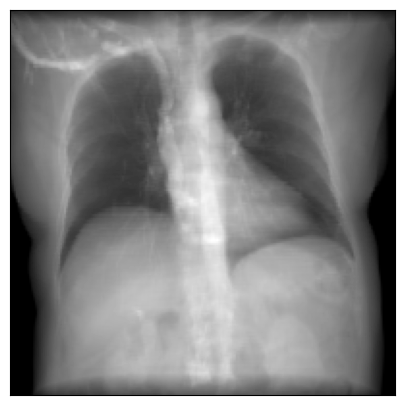

In [ ]:
#| code-fold: true
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

subject = load_example_ct()
drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device=device)

rot = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 850.0, 0.0]], device=device)
gt = drr(rot, xyz, parameterization="euler_angles", convention="ZXY")
gt = (gt - gt.min()) / (gt.max() - gt.min())
plot_drr(gt, ticks=False)
plt.show()

## 2. Initialize a moving DRR from a random volume

Below is an implementation of a simple volume reconstruction module with `DiffDRR`.

In [ ]:
from diffdrr.pose import convert


class Reconstruction(torch.nn.Module):
    def __init__(self, subject, device):
        super().__init__()
        self.drr = DRR(subject, sdd=1020.0, height=200, delx=2.0).to(device=device)

        # Replace the known density with an initial estimate
        self.density = torch.nn.Parameter(
            torch.zeros(*subject.volume.spatial_shape, device=device)
        )

    def forward(self, pose, **kwargs):
        source, target = self.drr.detector(pose, None)
        img = self.drr.render(self.density, source, target)
        return self.drr.reshape_transform(img, batch_size=len(pose))

## 3. Optimize!

- Render DRRs from the given camera poses
- Measure the loss between projected DRRs and the ground truth X-ray (here we use MSE)
- Update the estimate for the volume
- Repeat until converged!

  0%|                                                                       | 0/101 [00:00<?, ?it/s]

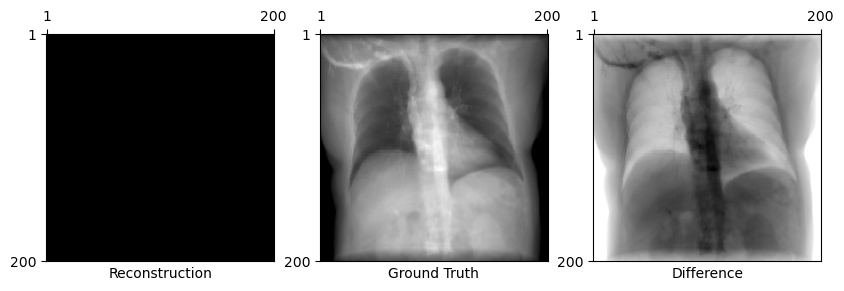

 24%|██████████████▋                                               | 24/101 [00:10<00:07,  9.75it/s]

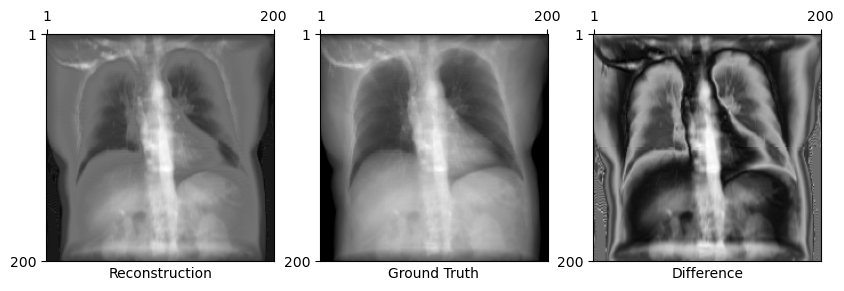

 48%|█████████████████████████████▍                                | 48/101 [00:11<00:02, 19.73it/s]

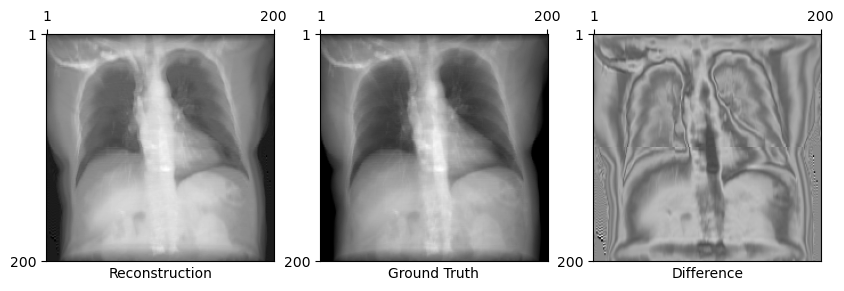

 74%|██████████████████████████████████████████████                | 75/101 [00:13<00:01, 20.97it/s]

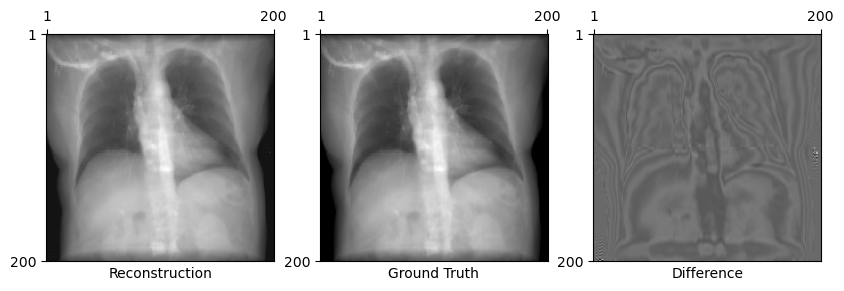

 98%|████████████████████████████████████████████████████████████▊ | 99/101 [00:14<00:00, 20.97it/s]

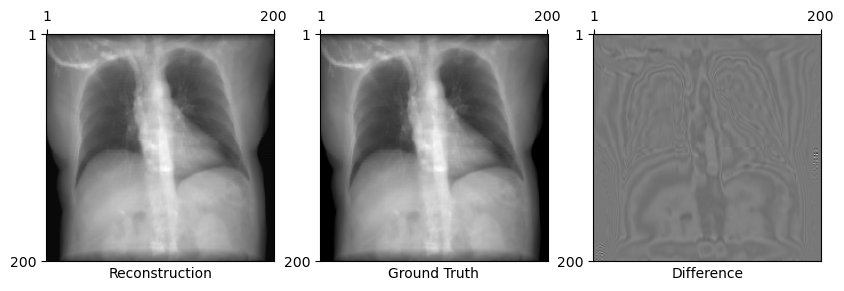

100%|█████████████████████████████████████████████████████████████| 101/101 [00:14<00:00,  6.91it/s]


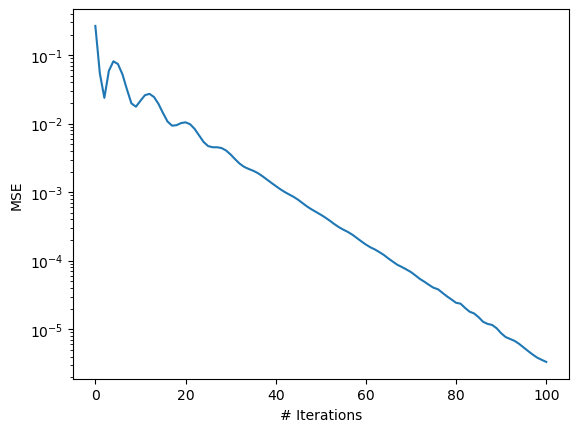

In [ ]:
#| code-fold: true
recon = Reconstruction(subject, device)
optimizer = torch.optim.Adam(recon.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

rot = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 850.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

losses = []
for itr in tqdm(range(101), ncols=100):
    optimizer.zero_grad()
    est = recon(pose)
    loss = criterion(est, gt)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if itr % 25 == 0:
        plot_drr(
            torch.concat([est, gt, est - gt]),
            title=["Reconstruction", "Ground Truth", "Difference"],
        )
        plt.show()

plt.plot(losses)
plt.xlabel("# Iterations")
plt.ylabel("MSE")
plt.yscale("log")
plt.show()

After optimizing for 100 iterations, we get a DRR that matches the input X-ray... even after starting with a randomly initialized voxelgrid! This demonstrates that differentiable rendering for volume reconstruction works with `DiffDRR`. But have we actually reconstructed something useful?

## Novel view synthesis

One way we can test the robustness of our reconstruction is by rendering DRRs from different poses.

First, let's try bringing the C-arm 10 mm closer to the patient. Instantly, we can see that the intensities of the rendered images looks off...

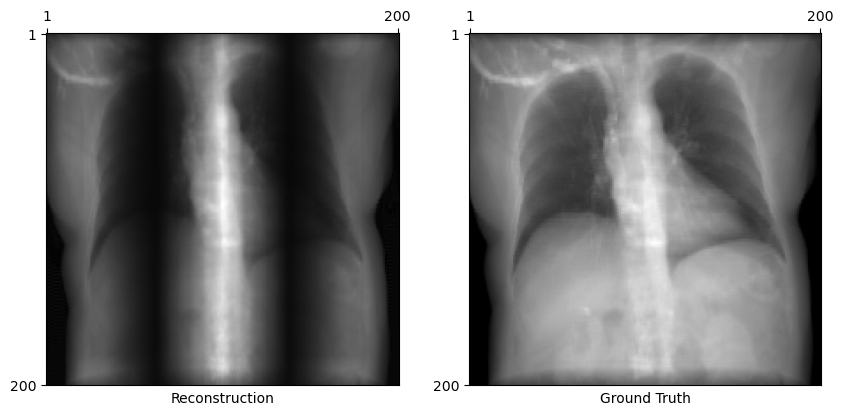

In [ ]:
rot = torch.tensor([[0.0, 0.0, 0.0]], device=device)
xyz = torch.tensor([[0.0, 840.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

plot_drr(
    torch.concat([recon(pose), drr(pose)]),
    title=["Reconstruction", "Ground Truth"],
)
plt.show()

Now let's try rotating the detector by 1 degree. Issues are also very apparent here!

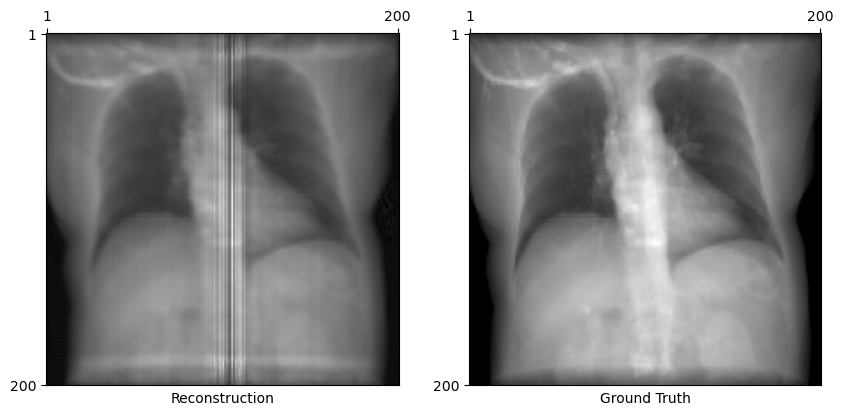

In [ ]:
rot = torch.tensor([[1.0, 0.0, 0.0]], device=device) / 180 * torch.pi
xyz = torch.tensor([[0.0, 850.0, 0.0]], device=device)
pose = convert(rot, xyz, parameterization="euler_angles", convention="ZXY")

plot_drr(
    torch.concat([recon(pose), drr(pose)]),
    title=["Reconstruction", "Ground Truth"],
)
plt.show()

These results should not be surprising. After all, we were trying to reconstruct a 3D volume from a single X-ray. Real reconstruction algorithms typically require >100 images to achieve good novel view synthesis. Methods that achieve reconstruction with <100 images typically have some neural shenanigans going on (which one can totally do with `DiffDRR`!).

## So what did we reconstruct?

We visualize slices from the volume reconstructed with `DiffDRR` and the original CT. The results are amusing! The takeaway is that the volume we reconstructed is incredibly overfit to produce the target X-ray. Every other X-ray that one might want to render is going to suffer horrible artifacts because our reconstruction isn't generalized at all.

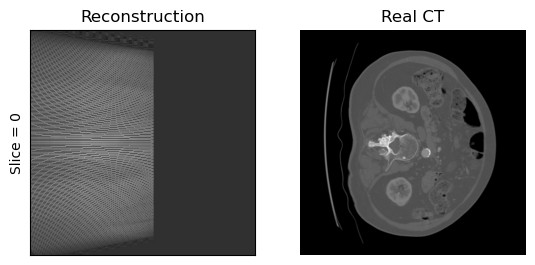

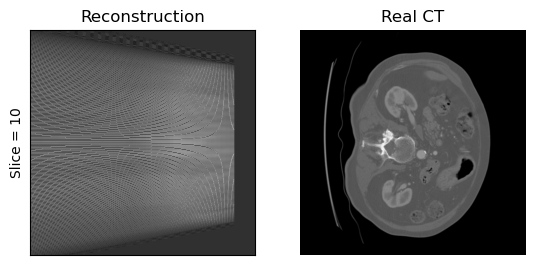

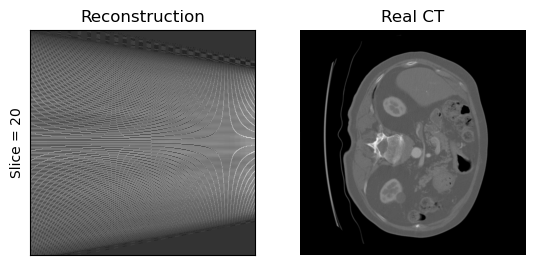

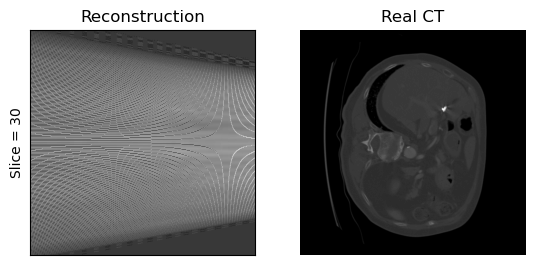

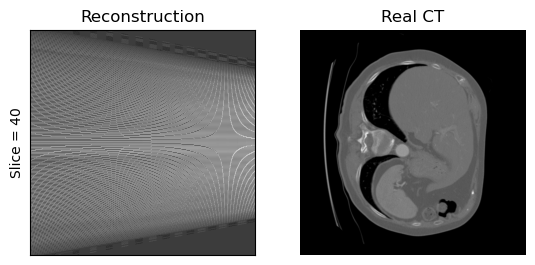

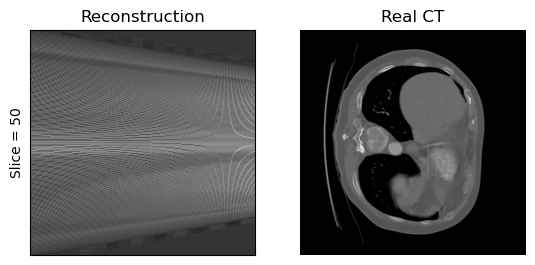

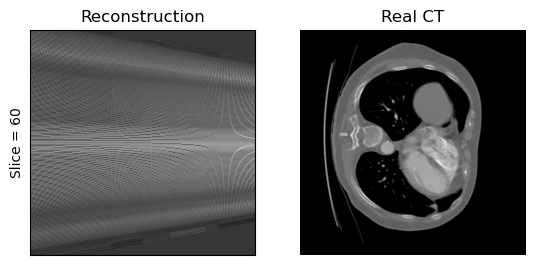

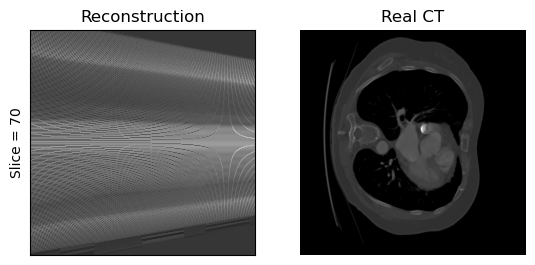

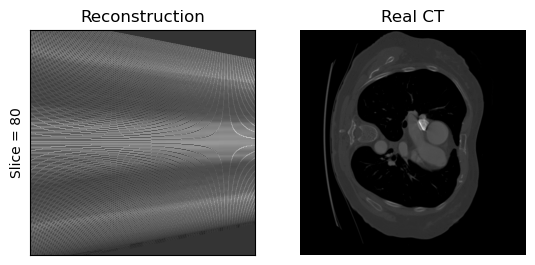

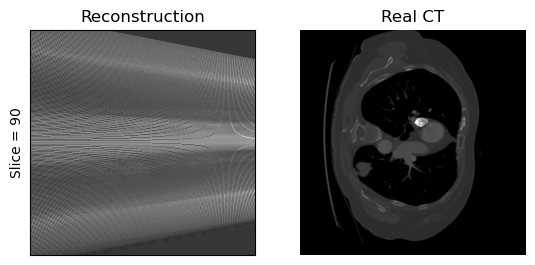

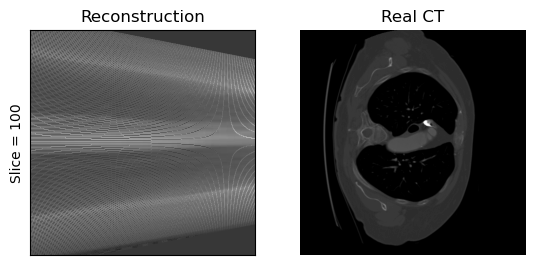

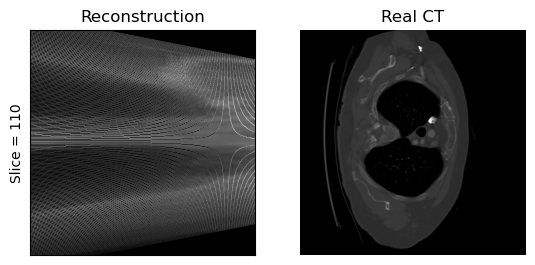

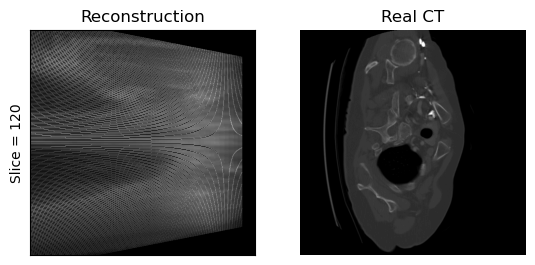

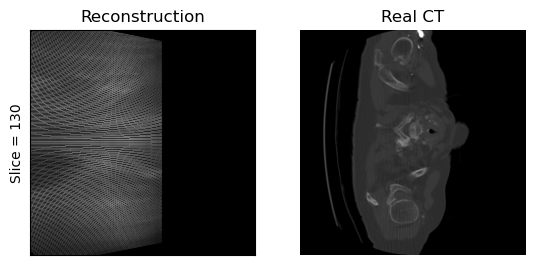

In [ ]:
#| code-fold: true
for jdx in range(0, 133, 10):
    plt.subplot(121)
    plt.imshow(recon.density[..., jdx].detach().cpu(), cmap="gray")
    plt.ylabel(f"Slice = {jdx}")
    plt.title("Reconstruction")
    plt.xticks([])
    plt.yticks([])
    plt.subplot(122)
    plt.imshow(drr.density[..., jdx].detach().cpu(), cmap="gray")
    plt.title("Real CT")
    plt.axis("off")
    plt.show()